In [4]:
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint

### select representative nuts region

In [2]:
nuts = gpd.read_file('/home/opengeohub/xuemeng/work_xuemeng/soc/data/NUTS_RG_20M_2021_3035.shp')
nuts = nuts.loc[nuts['CNTR_CODE']=='DE']
nuts = nuts.loc[nuts['LEVL_CODE']==3]

In [6]:
                
years = [2000,2004,2008,2012,2016,2020,2022]
positions = ['m','p025','p975']

results = {}

for po in positions:
    for iy in range(1,len(years)):
        
        year = years[iy-1]
        year_next = years[iy]
        ttprint(f'----------------{po}, {year}--------------------')
        
        raster_file = f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_{po}_30m_b0cm..20cm_{year}0101_{year_next}1231_eu_epsg.3035_v20240804.tif'

        stats = zonal_stats(nuts, raster_file, stats="mean", geojson_out=True)
        
        raster_name = f'ocd_{po}_{year}.{year_next}'
        results[raster_name] = [feature['properties']['mean'] for feature in stats]


# Add results back to the GeoDataFrame
for raster_name, means in results.items():
    nuts[raster_name + '_mean'] = means
    
nuts.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_de_mean.csv',index=False)

In [18]:
import pandas as pd
from scipy.stats import theilslopes

time = [2002, 2006, 2010, 2014, 2018, 2021]
ml = ['ocd_m_2000.2004_mean',
 'ocd_m_2004.2008_mean',
 'ocd_m_2008.2012_mean',
 'ocd_m_2012.2016_mean',
 'ocd_m_2016.2020_mean',
 'ocd_m_2020.2022_mean']

def calculate_theilsen(row):
    y = row[ml].values  # Extract values of the specified columns
    slope, intercept, _, _ = theilslopes(y, time)  # Calculate Theil-Sen slope
    return slope

nuts['ocd_mean_theilsen_slope'] = nuts.apply(calculate_theilsen, axis=1)


<Axes: >

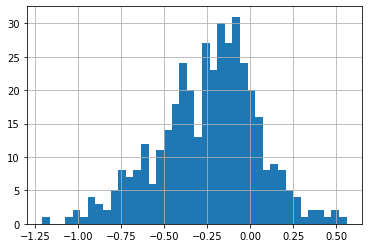

In [30]:
nuts['ocd_mean_theilsen_slope'].hist(bins=40)

In [74]:
nuts_slope = nuts.loc[nuts['ocd_mean_theilsen_slope'].abs()>0.5]
nuts_slope = nuts_slope.drop(columns = ['FID'])
nuts_slope.to_file('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3.de_mean_slope.gpkg',driver='GPKG')


nuts_example = nuts.loc[nuts['NUTS_NAME'].isin(['Unterallgäu','Memmingen, Kreisfreie Stadt'])]
nuts_example = nuts_example.drop(columns = ['FID'])
merged_nuts = gpd.GeoSeries([nuts_example.iloc[0].geometry, nuts_example.iloc[1].geometry]).unary_union
# merged_nuts.to_file('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_example_slope.gpkg',driver='GPKG')
merged_nuts_gdf = gpd.GeoDataFrame(geometry=[merged_nuts])
merged_nuts_gdf.crs = 'EPSG:3035'
merged_nuts_gdf.to_file('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_example_slope.gpkg', driver='GPKG')


In [67]:
results = {}
for po in positions:
    for iy in range(1,len(years)):
        
        year = years[iy-1]
        year_next = years[iy]
        ttprint(f'----------------{po}, {year}--------------------')
        
        raster_file = f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_{po}_30m_b0cm..20cm_{year}0101_{year_next}1231_eu_epsg.3035_v20240804.tif'

        stats = zonal_stats(merged_nuts, raster_file, stats="mean", geojson_out=True)
        
        raster_name = f'ocd_{po}_{year}.{year_next}'
        results[raster_name] = [feature['properties']['mean'] for feature in stats]
        
nuts_eg = pd.DataFrame(columns=['year','time','ocd_m','ocd_p025','ocd_p975'])
time = ['2000.2004','2004.2008','2008.2012','2012.2016','2016.2020','2020.2022']
year = [2002, 2006, 2010, 2014, 2018, 2021]
nuts_eg['time'] = time
nuts_eg['year'] = year


for keys in results:
    if keys.split('_')[1] == 'm':
        nuts_eg.loc[nuts_eg['time'] == keys.split('_')[2], 'ocd_m'] = results[keys][0]
    elif keys.split('_')[1] == 'p025':
        nuts_eg.loc[nuts_eg['time'] == keys.split('_')[2], 'ocd_p025'] = results[keys][0]
    elif keys.split('_')[1] == 'p975':
        nuts_eg.loc[nuts_eg['time'] == keys.split('_')[2], 'ocd_p975'] = results[keys][0]
        
nuts_eg.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_example_slope.csv',index=False)

[08:24:20] ----------------m, 2000--------------------
[08:24:21] ----------------m, 2004--------------------
[08:24:22] ----------------m, 2008--------------------
[08:24:22] ----------------m, 2012--------------------
[08:24:23] ----------------m, 2016--------------------
[08:24:23] ----------------m, 2020--------------------
[08:24:24] ----------------p025, 2000--------------------
[08:24:24] ----------------p025, 2004--------------------
[08:24:25] ----------------p025, 2008--------------------
[08:24:25] ----------------p025, 2012--------------------
[08:24:26] ----------------p025, 2016--------------------
[08:24:26] ----------------p025, 2020--------------------
[08:24:27] ----------------p975, 2000--------------------
[08:24:27] ----------------p975, 2004--------------------
[08:24:28] ----------------p975, 2008--------------------
[08:24:29] ----------------p975, 2012--------------------
[08:24:29] ----------------p975, 2016--------------------
[08:24:30] ----------------p975,

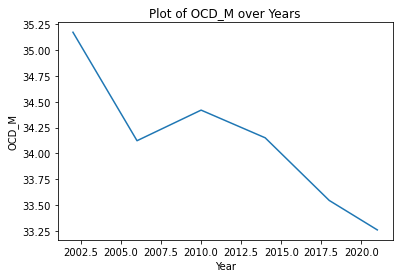

In [80]:
import matplotlib.pyplot as plt

# Now you can use plt to plot your data
plt.plot(nuts_eg['year'], nuts_eg['ocd_m']/10)
plt.xlabel('Year')
plt.ylabel('OCD_M')
plt.title('Plot of OCD_M over Years')
plt.show()

In [83]:
a = f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p975_30m_b0cm..20cm_20000101_20041231_eu_epsg.3035_v20240804.tif'


'ocd_p975_2000.2004'

In [84]:
nuts_eg

,year,time,ocd_m,ocd_p025,ocd_p975
0,2002,2000.2004,351.70661,205.405989,614.230616
1,2006,2004.2008,341.230623,197.032094,598.03357
2,2010,2008.2012,344.185494,209.137884,590.07742
3,2014,2012.2016,341.512451,209.992657,582.216718
4,2018,2016.2020,335.461051,204.44527,577.221545
5,2021,2020.2022,332.61574,200.769243,578.739499
